In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# Load dataset
df = pd.read_json("C:\\Users\\Shaurya\\Downloads\\Dataset\\politifact_factcheck_data.json", lines=True)

In [3]:
# Clean text data
def clean_text(text):
    # Implement text cleaning here
    return text

df['cleaned_statement'] = df['statement'].apply(clean_text)

# Binarize labels
binary_map = {'true': 1, 'mostly-true': 1, 'half-true': 1, 'mostly-false': 0, 'false': 0, 'pants-fire': 0}
df['binary_verdict'] = df['verdict'].map(binary_map)

# Tokenization and Padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_statement'])
sequences = tokenizer.texts_to_sequences(df['cleaned_statement'])
padded_sequences = pad_sequences(sequences, maxlen=200)

In [4]:
# Model parameters
vocab_size = 5000  
embedding_dim = 64
max_length = 200 
trunc_type = 'post'
padding_type = 'post'

In [5]:
# Build the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(SpatialDropout1D(0.4))  # Increased dropout for regularization
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))  # Increased dropout for regularization
model.add(Dense(1, activation='sigmoid'))

In [6]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           320000    
                                                                 
 spatial_dropout1d (Spatial  (None, 200, 64)           0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [7]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['binary_verdict'], test_size=0.2)

In [8]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/5
529/529 [==============================] - 123s 222ms/step - loss: 0.6303 - accuracy: 0.6385 - val_loss: 0.6038 - val_accuracy: 0.6566
Epoch 2/5
529/529 [==============================] - 125s 236ms/step - loss: 0.5589 - accuracy: 0.7103 - val_loss: 0.6111 - val_accuracy: 0.6540
Epoch 3/5
529/529 [==============================] - 125s 236ms/step - loss: 0.5207 - accuracy: 0.7389 - val_loss: 0.6253 - val_accuracy: 0.6493
Epoch 4/5
529/529 [==============================] - 121s 229ms/step - loss: 0.4825 - accuracy: 0.7677 - val_loss: 0.6451 - val_accuracy: 0.6422


In [9]:
# Evaluate the model
predictions = model.predict(X_test)
y_pred = [1 if p > 0.5 else 0 for p in predictions]

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

133/133 [==============================] - 5s 31ms/step
Accuracy:  0.6565823682344599

Confusion Matrix:
 [[1508  840]
 [ 613 1270]]

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.64      0.67      2348
           1       0.60      0.67      0.64      1883

    accuracy                           0.66      4231
   macro avg       0.66      0.66      0.66      4231
weighted avg       0.66      0.66      0.66      4231



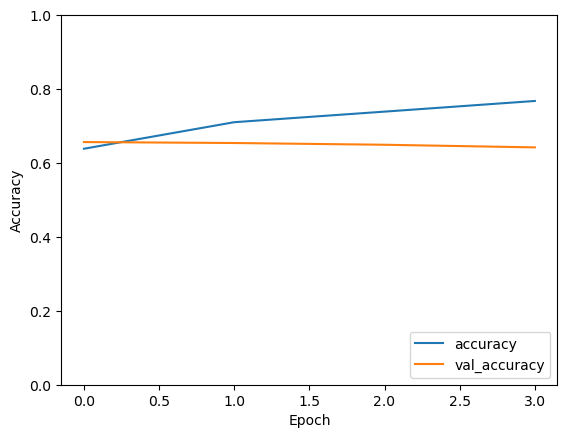

In [11]:
# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')